<a href="https://colab.research.google.com/github/HambaliMarcel/domainscan-surrounding-poc/blob/main/techstack_scanning_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install requests python-whois ipwhois geopy bs4 cryptography pandas matplotlib networkx dnspython

import requests
import whois
from ipwhois import IPWhois
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup
import socket
import ssl
from cryptography import x509
from cryptography.hazmat.backends import default_backend
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import dns.resolver
import re
import warnings


In [10]:

warnings.filterwarnings('ignore')

subdomains = [
    'www.pelindo.co.id',
    'portal.pelindo.co.id',
    'mail.pelindo.co.id',
    'my.pelindo.co.id',
    'portaverse.pelindo.co.id',
    'eproc.pelindo.co.id',
    'e-billing.pelindo.co.id',
    'centra.pelindo.co.id'
    # .. tambah lagi kalau perlu
]

base_domain = 'pelindo.co.id'

def is_live(subdomain):
    for protocol in ['https://', 'http://']:
        try:
            response = requests.get(f'{protocol}{subdomain}', timeout=10, verify=False)
            if response.status_code == 200:
                return protocol
        except:
            continue
    return None

def get_ssl_certificate(subdomain):
    ctx = ssl.create_default_context()
    s = ctx.wrap_socket(socket.socket(), server_hostname=subdomain)
    try:
        s.settimeout(5)
        s.connect((subdomain, 443))
        cert_bin = s.getpeercert(True)
        cert = x509.load_der_x509_certificate(cert_bin, default_backend())
        issuer = cert.issuer.rfc4514_string()
        subject = cert.subject.rfc4514_string()
        valid_from = cert.not_valid_before
        valid_until = cert.not_valid_after
        return {
            'issuer': issuer,
            'subject': subject,
            'valid_from': valid_from.strftime('%Y-%m-%d'),
            'valid_until': valid_until.strftime('%Y-%m-%d')
        }
    except:
        return None

def get_geolocation(ip_address):
    try:
        response = requests.get(f'https://ipapi.co/{ip_address}/json/', timeout=5).json()
        city = response.get('city')
        region = response.get('region')
        country = response.get('country_name')
        if city and region and country:
            return f"{city}, {region}, {country}"
        elif country:
            return country
        else:
            return 'Location not found'
    except:
        return 'Error retrieving location'

def get_dns_records(subdomain):
    records = {}
    try:
        answers = dns.resolver.resolve(subdomain, 'A', lifetime=5)
        records['A'] = [r.to_text() for r in answers]
    except:
        records['A'] = []
    try:
        answers = dns.resolver.resolve(subdomain, 'MX', lifetime=5)
        records['MX'] = [r.exchange.to_text() for r in answers]
    except:
        records['MX'] = []
    try:
        answers = dns.resolver.resolve(subdomain, 'NS', lifetime=5)
        records['NS'] = [r.to_text() for r in answers]
    except:
        records['NS'] = []
    return records

technology_categories = {
    'Web Servers': 'Server',
    'Programming Languages': 'Backend',
    'Frameworks': 'Backend',
    'JavaScript Libraries': 'Frontend',
    'Content Management Systems': 'Backend',
    'Web Frameworks': 'Backend',
    'Operating Systems': 'Server',
    'Databases': 'Backend',
    'Analytics': 'Libraries/3rd Party',
    'Widgets': 'Frontend',
    'Font Scripts': 'Frontend',
    'Tag Managers': 'Libraries/3rd Party',
    'SSL Certificates': 'Certificates',
    'CDN': 'Network',
    'Reverse Proxy': 'Network',
    'Load Balancers': 'Network',
    'Email Hosting Providers': 'Network',
    'DNS Servers': 'Network',
    'Advertising Networks': 'Libraries/3rd Party',
    # .. tambah lagi kalau perlu
}

technology_signatures = {
    'Web Servers': {
        'Nginx': {'headers': {'Server': r'nginx'}},
        'Apache': {'headers': {'Server': r'Apache'}},
        'IIS': {'headers': {'Server': r'Microsoft-IIS'}},
    },
    'Programming Languages': {
        'PHP': {'headers': {'X-Powered-By': r'PHP'}},
        'Python': {'text': [r'django', r'python']},
        'Ruby': {'headers': {'X-Powered-By': r'Ruby'}},
    },
    'JavaScript Libraries': {
        'jQuery': {'scripts': [r'jquery.*\.js']},
        'React': {'scripts': [r'react.*\.js'], 'text': [r'__REACT_DEVTOOLS_GLOBAL_HOOK__']},
        'AngularJS': {'scripts': [r'angular.*\.js'], 'attributes': ['ng-app', 'ng-controller']},
    },
    'Content Management Systems': {
        'WordPress': {'meta_generator': [r'WordPress'], 'scripts': [r'wp-includes']},
        'Drupal': {'meta_generator': [r'Drupal'], 'scripts': [r'drupal\.js']},
    },
    'SSL Certificates': {
        "Let's Encrypt": {'ssl_issuer': [r"Let's Encrypt"]},
    },
    # .. tambah lagi kalau perlu
}

def detect_technologies(response, content, ssl_info):
    detected_technologies = {}
    soup = BeautifulSoup(content, 'html.parser')
    for category, techs in technology_signatures.items():
        mapped_category = technology_categories.get(category, 'Others')
        detected_technologies.setdefault(mapped_category, [])
        for tech_name, signatures in techs.items():
            found = False
            if 'headers' in signatures:
                for header, pattern in signatures['headers'].items():
                    header_value = response.headers.get(header, '')
                    if re.search(pattern, header_value, re.IGNORECASE):
                        found = True
                        break
            if not found and 'meta_generator' in signatures:
                meta_tag = soup.find('meta', attrs={'name': 'generator'})
                if meta_tag and any(re.search(pat, meta_tag.get('content', ''), re.IGNORECASE) for pat in signatures['meta_generator']):
                    found = True
            if not found and 'scripts' in signatures:
                scripts = soup.find_all('script', src=True)
                for script in scripts:
                    src = script['src']
                    if any(re.search(pat, src, re.IGNORECASE) for pat in signatures['scripts']):
                        found = True
                        break
            if not found and 'attributes' in signatures:
                for attr in signatures['attributes']:
                    if soup.find(attrs={attr: True}):
                        found = True
                        break
            if not found and 'text' in signatures:
                if any(re.search(pat, content.decode('utf-8', 'ignore'), re.IGNORECASE) for pat in signatures['text']):
                    found = True
            if not found and 'ssl_issuer' in signatures and ssl_info:
                issuer = ssl_info.get('issuer', '')
                if any(re.search(pat, issuer, re.IGNORECASE) for pat in signatures['ssl_issuer']):
                    found = True
            if found:
                if tech_name not in detected_technologies[mapped_category]:
                    detected_technologies[mapped_category].append(tech_name)
    return detected_technologies

results = []

for subdomain in subdomains:
    protocol = is_live(subdomain)
    if protocol:
        print(f'\nAnalyzing {subdomain} ({protocol})')
        data = {'Subdomain': subdomain, 'Protocol': protocol}
        try:
            domain_info = whois.whois(base_domain)
            owner = domain_info.get('org') or domain_info.get('name') or 'No owner info available'
            data['Owner'] = owner
        except:
            data['Owner'] = 'Error retrieving WHOIS info'
        ssl_info = get_ssl_certificate(subdomain)
        if ssl_info:
            data['SSL Issuer'] = ssl_info['issuer']
            data['SSL Subject'] = ssl_info['subject']
            data['SSL Valid From'] = ssl_info['valid_from']
            data['SSL Valid Until'] = ssl_info['valid_until']
        else:
            data['SSL Issuer'] = 'N/A'
            data['SSL Subject'] = 'N/A'
            data['SSL Valid From'] = 'N/A'
            data['SSL Valid Until'] = 'N/A'
        try:
            ip_address = socket.gethostbyname(subdomain)
            data['IP Address'] = ip_address
            location = get_geolocation(ip_address)
            data['Location'] = location
        except:
            data['IP Address'] = 'Error'
            data['Location'] = 'Error'
        try:
            response = requests.get(f'{protocol}{subdomain}', timeout=10, verify=False)
            data['Response Headers'] = dict(response.headers)
            security_headers = [
                'Strict-Transport-Security',
                'Content-Security-Policy',
                'X-Content-Type-Options',
                'X-Frame-Options',
                'X-XSS-Protection'
            ]
            headers_info = {}
            for header in security_headers:
                header_value = response.headers.get(header)
                if header_value:
                    headers_info[header] = header_value
            data['Security Headers'] = headers_info
            content = response.content
        except:
            data['Response Headers'] = {}
            data['Security Headers'] = {}
            content = b''
        try:
            soup = BeautifulSoup(content, 'html.parser')
            title = soup.title.string.strip() if soup.title else 'No title available'
            description_tag = soup.find('meta', attrs={'name': 'description'})
            description = description_tag['content'].strip() if description_tag else 'No description available'
            data['Site Title'] = title
            data['Site Description'] = description
        except:
            data['Site Title'] = 'Error retrieving title'
            data['Site Description'] = 'Error retrieving description'
        tech_detected = detect_technologies(response, content, ssl_info)
        data['Technologies'] = tech_detected
        dns_records = get_dns_records(subdomain)
        data['DNS Records'] = dns_records
        results.append(data)
    else:
        print(f'\n{subdomain} is not live or not accessible.')

df = pd.DataFrame(results)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
df.fillna('N/A', inplace=True)


columns_order = [
    'Subdomain', 'Protocol', 'Owner', 'IP Address', 'Location',
    'SSL Issuer', 'SSL Subject', 'SSL Valid From', 'SSL Valid Until',
    'Site Title', 'Site Description', 'Technologies', 'Security Headers',
    'DNS Records', 'Response Headers'
]
df = df[columns_order]

df



Analyzing www.pelindo.co.id (https://)

portal.pelindo.co.id is not live or not accessible.

Analyzing mail.pelindo.co.id (https://)

Analyzing my.pelindo.co.id (https://)

Analyzing portaverse.pelindo.co.id (https://)

Analyzing eproc.pelindo.co.id (http://)

Analyzing e-billing.pelindo.co.id (https://)

Analyzing centra.pelindo.co.id (https://)


,Subdomain,Protocol,Owner,IP Address,Location,SSL Issuer,SSL Subject,SSL Valid From,SSL Valid Until,Site Title,Site Description,Technologies,Security Headers,DNS Records,Response Headers
0,www.pelindo.co.id,https://,No owner info available,103.41.110.141,"Kamal, East Java, Indonesia","CN=DigiCert Global G2 TLS RSA SHA256 2020 CA1,O=DigiCert Inc,C=US","CN=*.pelindo.co.id,O=PT Pelabuhan Indonesia (Persero),L=Jakarta,C=ID",2024-03-07,2025-04-07,Error retrieving title,Error retrieving description,"{'Server': ['Nginx'], 'Backend': ['PHP'], 'Frontend': ['jQuery'], 'Certificates': []}",{},"{'A': ['103.41.110.141'], 'MX': [], 'NS': []}","{'Server': 'nginx/1.20.1', 'Content-Type': 'text/html; charset=UTF-8', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'X-Powered-By': 'PHP/7.4.24', 'Cache-Control': 'no-cache, private', 'Date': 'Sat, 14 Sep 2024 08:57:58 GMT', 'Set-Cookie': 'XSRF-TOKEN=eyJpdiI6Imk3ZUFMZmFmeTE1R0Q2TkRrT1BmSnc9PSIsInZhbHVlIjoiTlVKbHk5dlNCQkgvVWwzcnJSOXlDZGFVTGE5ZEs4M0xZQkFnSGlBYnRabURQRk8rRURqWk1sdUorUGFZcGpoem9vNUIxWUxsSDYrSUdkOC9CRGVmVmJJL0g1UjZ5M21wZlkxZTkxeXhnMmJFb1FXb1Bic0pBajZ1K2E1ZlVJTWUiLCJtYWMiOiIxNzg3MTEwZmY4MjFiNzFiNmZlNzQ0YmNiOTc3YmEzNGM1ZGU2MzkxMGQyNzIxNzkwY2RjZjRjMWYwNTViZjZjIiwidGFnIjoiIn0%3D; expires=Sat, 14-Sep-2024 10:57:58 GMT; Max-Age=7200; path=/; samesite=lax, pelindo_session=eyJpdiI6Ik5wK2VFc1k3TEh6VE5SUG5VMzNScUE9PSIsInZhbHVlIjoiM3BQR2NMYnczRlhRaGpkMzV2NDNmdVZGdy9KLy96WEJvZUR2cVBXZG9IaTNoUE5QRm85cGVOZ1paQnUzRXRuOG44TXdDL1FBdGR3clJIYTdZS3ZVcmEwVnR5dUpiL1lVRy9SeXJob2VkeWNvcE5MZkgvd3RBVUZWQ3NPaWR6TXIiLCJtYWMiOiI2NDFmMWVmODM5YWFkNWY0ZTU3Y2I1ODdjNGY2NTE0NjVhOWJiMzU0M2Q0YjczNTdkMWEwMWYxY2ZmMTc4NjM3IiwidGFnIjoiIn0%3D; expires=Sat, 14-Sep-2024 10:57:58 GMT; Max-Age=7200; path=/; httponly; samesite=lax'}"
1,mail.pelindo.co.id,https://,No owner info available,103.41.110.20,"Kamal, East Java, Indonesia","CN=DigiCert Global G2 TLS RSA SHA256 2020 CA1,O=DigiCert Inc,C=US","CN=*.pelindo.co.id,O=PT Pelabuhan Indonesia (Persero),L=Jakarta,C=ID",2024-03-07,2025-04-07,Outlook Web App,No description available,"{'Server': ['IIS'], 'Backend': [], 'Frontend': [], 'Certificates': []}",{'X-Frame-Options': 'SAMEORIGIN'},"{'A': ['103.41.110.20'], 'MX': [], 'NS': []}","{'Cache-Control': 'no-cache, no-store', 'Pragma': 'no-cache', 'Content-Type': 'text/html; charset=utf-8', 'Expires': '-1', 'Server': 'Microsoft-IIS/8.5', 'request-id': '120d236d-76b6-4e2d-abc8-cceea81ba711', 'X-Frame-Options': 'SAMEORIGIN', 'X-AspNet-Version': '4.0.30319', 'X-Powered-By': 'ASP.NET', 'Date': 'Sat, 14 Sep 2024 09:02:36 GMT', 'Content-Length': '56252'}"
2,my.pelindo.co.id,https://,No owner info available,103.41.110.115,"Kamal, East Java, Indonesia","CN=DigiCert Global G2 TLS RSA SHA256 2020 CA1,O=DigiCert Inc,C=US","CN=*.pelindo.co.id,O=PT Pelabuhan Indonesia (Persero),L=Jakarta,C=ID",2024-03-07,2025-04-07,My Pelindo | Landing page,Latest updates and statistic charts,"{'Server': ['Nginx'], 'Backend': [], 'Frontend': [], 'Certificates': []}",{},"{'A': ['103.41.110.115'], 'MX': [], 'NS': []}","{'Server': 'nginx', 'Date': 'Sat, 14 Sep 2024 09:02:49 GMT', 'Content-Type': 'text/html; charset=UTF-8', 'Content-Length': '2223', 'Connection': 'keep-alive', 'Cache-Control': 'no-cache, private', 'Set-Cookie': 'XSRF-TOKEN=eyJpdiI6Img4aVQxYjRyVWcxcEpEcCttNmtrNWc9PSIsInZhbHVlIjoiY1wvSVVYVHpsTU1SSmhHb042dHI4bmtId2dLZnJWNjk4SUhPTmhBQjhsd0NpblUzbHZCV29sUDhpdk1qWDFubURTRlNrVnNMM0ttR2RDYVcrNkFHVFNBPT0iLCJtYWMiOiI2N2QwNGQwNzAwNjZhZGJkOTA4ZDU5M2YzNjY1MGI5ZDZiY2M3OTBjMmI3M2JiMDlhZjVmNmYzMjUzMGMwMzY3In0%3D; expires=Sat, 14-Sep-2024 11:02:29 GMT; Max-Age=7200; path=/, mypelindo_admin_session=eyJpdiI6ImMzb2dxZXhVVHphWlZGMkdUcnF5dHc9PSIsInZhbHVlIjoidTVmZlFYZUxJTjJ3b1RUakpuTCtSZjd6RFZkUE1zS0hkNEExdTNTTlFINThzbStmcHJCVmx1UTlOU2FxaDF5VnMxS3g2TXhzVytzb3I3YWFYQW4xK2c9PSIsIm1hYyI6ImJkZGJiMmU2ZmJlZDU5Zjk2YWI4NzQ3NjhjZjBhNjlkNjFhODQ4ZTIyOTYxNDhkMTI2OGRmOTRhYmMzY2RlNTkifQ%3D%3D; expires=Sat, 14-Sep-2024 11:02:29 GMT; Max-Age=7200; path=/; httponly', 'Vary': 'Accept-

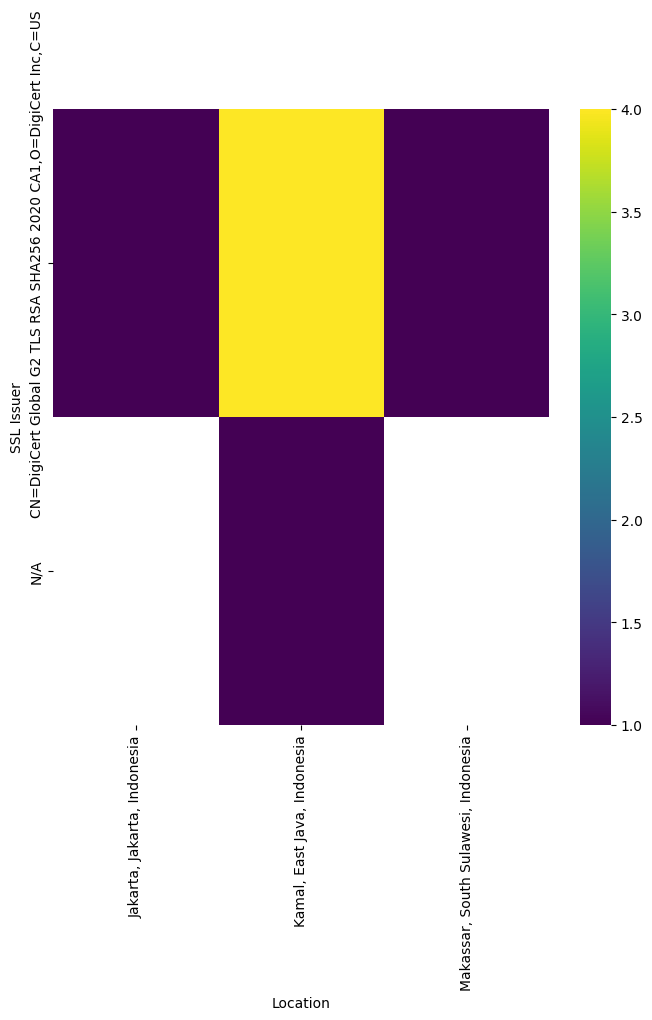

In [12]:
# @title Location vs SSL Issuer

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['SSL Issuer'].value_counts()
    for x_label, grp in df.groupby('Location')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Location')
_ = plt.ylabel('SSL Issuer')

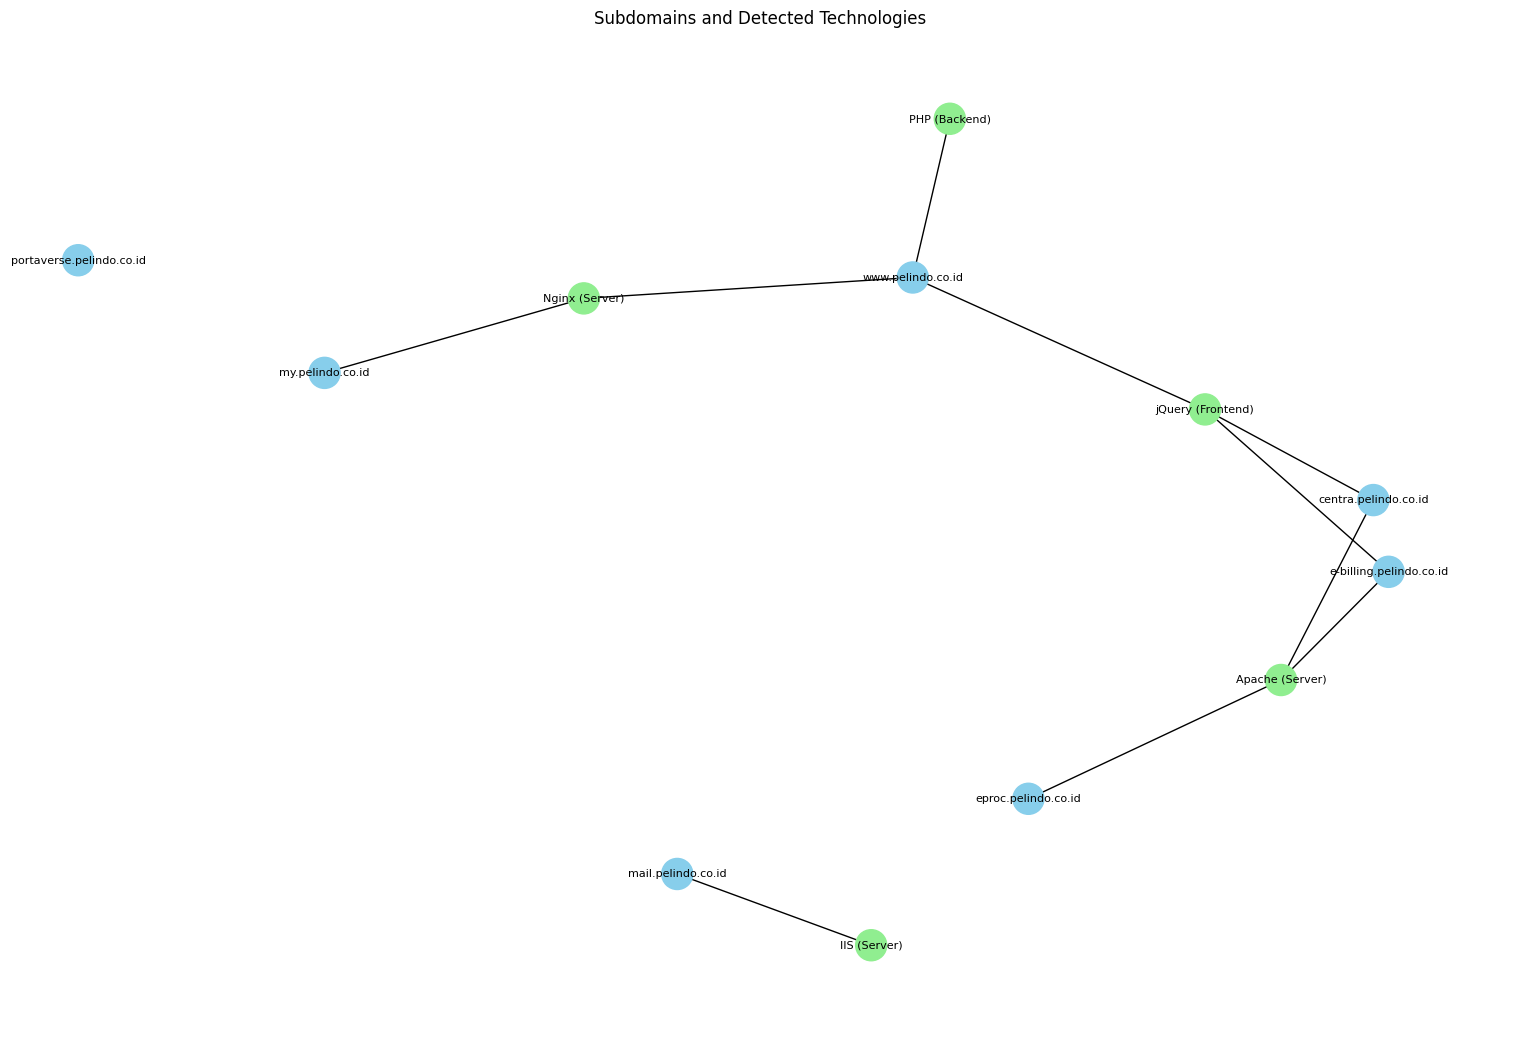

In [11]:
def create_tech_graph(results):
    G = nx.Graph()
    for data in results:
        subdomain = data['Subdomain']
        G.add_node(subdomain, type='subdomain')
        technologies = data.get('Technologies', {})
        for category, tech_list in technologies.items():
            for tech in tech_list:
                tech_node = f"{tech} ({category})"
                G.add_node(tech_node, type='technology', category=category)
                G.add_edge(subdomain, tech_node)
    return G

G = create_tech_graph(results)
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=0.5)
node_colors = []
for node in G.nodes(data=True):
    if node[1]['type'] == 'subdomain':
        node_colors.append('skyblue')
    else:
        node_colors.append('lightgreen')
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=8)
plt.title('Subdomains and Detected Technologies')
plt.show()
